In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from os import listdir
from os.path import isfile, join

import re

In [2]:
def removeExtension(file_name):
    idx = -1
    for i, c in enumerate(file_name):
        if c == '.':
            idx = i
            break
    if idx >= 0:
        return file_name[:idx]
    return file_name

In [3]:
SUBMISSIONS_DIR = './submissions/'
MATCH_RESULTS_DIR = './match_results/'

In [4]:
files = sorted([f for f in listdir(SUBMISSIONS_DIR) if isfile(join(SUBMISSIONS_DIR, f)) and f[-1] != 'c'])
names = sorted([removeExtension(f) for f in files])

teams = list(zip(files, names))

In [5]:
match_results_df = pd.DataFrame(columns=['Team', 'Opponent', 'Wins', 'Losses', 'Ties', 'Invalid'])

In [6]:
def process_raw_outcome(outcome):
    return outcome.replace('\n', '')

for i in range(len(teams)):
    for j in range(i + 1, len(teams)):
        if i == j:
            continue
        
        file_a, name_a = teams[i]
        file_b, name_b = teams[j]
        
        # Get match results for team a vs team b
        match_data_file_name = name_a + '_vs_' + name_b + '.dat'
        try:
            match_data_file = open(join(MATCH_RESULTS_DIR, match_data_file_name), 'r')
        except FileNotFoundError:
            continue
        outcomes = [process_raw_outcome(l) for l in match_data_file]
        outcomes = outcomes[:15]
        match_data_file.close()
        
        # Get DataFrame props
        num_rows, num_cols = match_results_df.shape
        
        # Insert row if doesn't exist or reset row
        index_a, index_b = -1, -1
        for k in range(num_rows):
            row = match_results_df.loc[k]
            if row.Team == name_a and row.Opponent == name_b:
                index_a = k
            if row.Team == name_b and row.Opponent == name_a:
                index_b = k
        if index_a == -1 and index_b == -1:
            index_a, index_b = num_rows, num_rows + 1
        elif index_a == -1:
            index_a = num_rows
        elif index_b == -1:
            index_b == num_rows
        
        win, loss, tied, invalid = 0, 0, 0, 0
        for outcome in outcomes:
            if outcome == name_a:
                win += 1
            elif outcome == name_b:
                loss += 1
            elif outcome == 'tied':
                tied += 1
            elif outcome == 'invalid':
                invalid += 1
            else:
                raise Error('Invalid match outcome')
        match_results_df.loc[index_a] = [name_a, name_b, win, loss, tied, invalid]
        match_results_df.loc[index_b] = [name_b, name_a, loss, win, tied, invalid]

In [7]:
match_results_df.shape

(288, 6)

In [8]:
match_results_df.head()

,Team,Opponent,Wins,Losses,Ties,Invalid
0,MyOffenseTeam_Xing_Jin,RyanOng_notarealTeam_RYAN_BRYCE_ONG,0,0,0,0
1,RyanOng_notarealTeam_RYAN_BRYCE_ONG,MyOffenseTeam_Xing_Jin,0,0,0,0
2,MyOffenseTeam_Xing_Jin,TeamJamesAnanth_Ananth_Agarwal,0,0,0,0
3,TeamJamesAnanth_Ananth_Agarwal,MyOffenseTeam_Xing_Jin,0,0,0,0
4,MyOffenseTeam_Xing_Jin,balancedReflexes,0,0,0,0


In [9]:
match_results_df[match_results_df['Invalid'] > 10].shape

(12, 6)

# Invalid Submissions

In [10]:
invalid_dict = dict(zip(names, [0] * len(names)))
for file, name in teams:
    invalids = match_results_df[(match_results_df['Invalid'] > 4) & (match_results_df['Team'] == name)].shape[0]
    invalid_dict[name] += invalids
    
INVALID_THRESH = 5
invalid_list = [name for name in names if invalid_dict[name] > INVALID_THRESH]
invalid_list

['balancedReflexes']

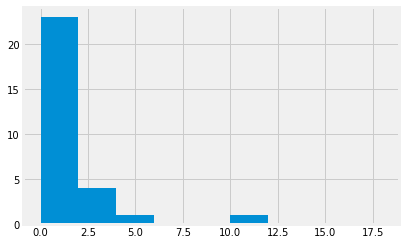

In [11]:
plt.hist(list(invalid_dict.values()), bins=np.arange(0, 20, 2))
plt.show()

# Elo

In [12]:
elo_dict = dict(zip(names, [1500] * len(names)))

In [13]:
match_results_df['margin'] = match_results_df.Wins - match_results_df.Losses

In [14]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K=20):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [15]:
sample_match_results_df = match_results_df.sample(match_results_df.shape[0])

In [16]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in sample_match_results_df.itertuples():
    # Get key data from current row
    w = row.Team
    l = row.Opponent
    margin = row.margin
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w],
                              elo_dict[l], 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [17]:
win_elo = []
for w in w_elo:
    if isinstance(w, complex):
        win_elo.append(w.real)
    else:
        win_elo.append(w)
        
loss_elo = []
for l in l_elo:
    if isinstance(l, complex):
        loss_elo.append(l.real)
    else:
        loss_elo.append(l)

In [18]:
sample_match_results_df['w_elo'] = win_elo
sample_match_results_df['l_elo'] = loss_elo

In [19]:
sample_match_results_df.tail(10)

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
179,myTeam_ANISH_SAHA,balancedReflexes,2,11,1,1,-9,1457.075768,1552.589753
253,myTeam_Shannon_Shih,logan_howard_myTeam_Logan_Howard,0,0,0,3,0,1503.910474,1643.309769
259,myTeam_Yuxi_Feng,logan_howard_myTeam_Logan_Howard,0,8,1,1,-8,1474.781229,1649.201625
243,myTeam_Jiarong_Li,logan_howard_myTeam_Logan_Howard,0,13,1,1,-13,1470.653672,1659.515893
202,balancedReflexes,myTeam_SEAN_ADAM_MEDIN,0,0,0,3,0,1555.284706,1504.582321
134,TeamJamesAnanth_Ananth_Agarwal,myTeam_Danny_Liang_1,0,0,0,0,0,1501.083740,1479.497098
115,logan_howard_myteam_Logan_Howard_1,TeamJamesAnanth_Ananth_Agarwal,0,0,0,0,0,1561.717959,1498.525396
47,myTeam_SEAN_ADAM_MEDIN,MyOffenseTeam_Xing_Jin,0,0,0,0,0,1507.783707,1500.569414
261,logan_howard_myteam_Logan_Howard_2,logan_howard_myteam_Logan_Howard_1,1,1,3,0,0,1507.367080,1557.790832
223,myTeam3_SEAN_ADAM_MEDIN,logan_howard_myTeam_Logan_Howard,0,1,1,13,-1,1501.652364,1655.694940


In [20]:
final_elo_dict = dict(zip(names, [1500] * len(names)))

In [21]:
for row in sample_match_results_df.itertuples():
    final_elo_dict[row.Team] = row.w_elo
    final_elo_dict[row.Opponent] = row.l_elo

In [22]:
rankings = zip(final_elo_dict.keys(), final_elo_dict.values())
rankings = [r for r in rankings if r[0] not in invalid_list]
rankings = sorted(list(rankings), key=lambda x: -x[1])
place = 1
for name, elo in rankings:
    print('%d.' %place, name, '(%.3f)' % elo)
    place += 1

1. logan_howard_myTeam_Logan_Howard (1655.695)
2. logan_howard_myteam_Logan_Howard_1 (1557.791)
3. masterReflexes (1512.486)
4. myTeam_SEAN_ADAM_MEDIN (1507.784)
5. logan_howard_myteam_Logan_Howard_2 (1507.367)
6. myTeam_Swapnil_Das (1506.074)
7. myTeam_Shannon_Shih (1503.910)
8. myTeam_Jesse_Zhang_Zhang (1503.186)
9. myTeam_Laura_Smith (1503.094)
10. myTeam_Joshua_Yurtsever (1502.948)
11. myTeam_Laura_Smith_1 (1502.693)
12. RyanOng_notarealTeam_RYAN_BRYCE_ONG (1502.572)
13. myTeam3_SEAN_ADAM_MEDIN (1501.652)
14. myTeam_Xing_Jin (1501.067)
15. MyOffenseTeam_Xing_Jin (1500.569)
16. TeamJamesAnanth_Ananth_Agarwal (1498.525)
17. myTeam_BRYAN_CHIEN_FEN_TONG (1492.215)
18. myTeam_Danny_Liang (1482.283)
19. myTeam_Danny_Liang_1 (1479.497)
20. myTeam3_laser_ALI_KHALEEL_AHMED (1477.961)
21. myTeam_Yuxi_Feng (1474.781)
22. myTeam_Jennifer_Zou (1473.270)
23. myTeam_Gao_Xian_Peh (1472.482)
24. myTeam_Jiarong_Li (1470.654)
25. myTeam3_ALI_KHALEEL_AHMED (1468.732)
26. myTeam1_ALI_KHALEEL_AHMED (146

# Manual Investigation

In [375]:
match_results_df[match_results_df['Team'] == 'myTeam2_SEAN_ADAM_MEDIN']

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
9,myTeam2_SEAN_ADAM_MEDIN,PacBot_Kevin_Cao,14,1,0,0,13,1518.703972,1492.796535
49,myTeam2_SEAN_ADAM_MEDIN,baselineTeam2_Rachel_Li,11,0,4,0,11,1534.475962,1480.918982
87,myTeam2_SEAN_ADAM_MEDIN,baselineTeam2_Raghav_Anand,8,0,7,0,8,1546.188778,1470.291665
123,myTeam2_SEAN_ADAM_MEDIN,cleverTeam_Dylan_Rowe,14,1,0,0,13,1563.836311,1497.053899
157,myTeam2_SEAN_ADAM_MEDIN,coolTeam_SONTHAYA_VISUTHIKRAISEE,14,0,1,0,14,1581.767778,1477.171142
190,myTeam2_SEAN_ADAM_MEDIN,myTeam3_4foodNum_ALI_KHALEEL_AHMED,8,1,6,0,7,1588.774362,1527.586578
192,myTeam2_SEAN_ADAM_MEDIN,myTeam_ANISH_SAHA,14,1,0,0,13,1600.976141,1488.648083
194,myTeam2_SEAN_ADAM_MEDIN,myTeam_ANTON_SHELBY_OYUNG_1,15,0,0,0,15,1618.535587,1483.775425
196,myTeam2_SEAN_ADAM_MEDIN,myTeam_Benjamin_Carlson_1,11,0,4,0,11,1636.719529,1508.258120
198,myTeam2_SEAN_ADAM_MEDIN,myTeam_Christina_Baek_1,3,4,8,0,-1,1646.388325,1566.389481


In [376]:
match_results_df[match_results_df['Team'] == 'myTeam_Christina_Baek_1']

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
19,myTeam_Christina_Baek_1,PacBot_Kevin_Cao,14,1,0,0,13,1517.532984,1446.143796
59,myTeam_Christina_Baek_1,baselineTeam2_Rachel_Li,7,1,7,0,6,1527.067503,1475.138946
97,myTeam_Christina_Baek_1,baselineTeam2_Raghav_Anand,13,0,2,0,13,1544.665705,1472.609329
133,myTeam_Christina_Baek_1,cleverTeam_Dylan_Rowe,10,3,2,0,7,1554.449761,1443.908978
167,myTeam_Christina_Baek_1,coolTeam_SONTHAYA_VISUTHIKRAISEE,11,1,3,0,10,1568.095332,1473.764792
199,myTeam_Christina_Baek_1,myTeam2_SEAN_ADAM_MEDIN,4,3,8,0,1,1571.680225,1641.097582
229,myTeam_Christina_Baek_1,myTeam3_4foodNum_ALI_KHALEEL_AHMED,1,6,8,0,-5,1562.742009,1583.832032
257,myTeam_Christina_Baek_1,myTeam_ANISH_SAHA,12,1,2,0,11,1576.727804,1432.680007
283,myTeam_Christina_Baek_1,myTeam_ANTON_SHELBY_OYUNG_1,11,0,4,0,11,1590.451281,1431.723466
307,myTeam_Christina_Baek_1,myTeam_Benjamin_Carlson_1,10,1,4,0,9,1602.596647,1496.504425


In [377]:
match_results_df[match_results_df['Team'] == 'myTeam3_4foodNum_ALI_KHALEEL_AHMED']

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
11,myTeam3_4foodNum_ALI_KHALEEL_AHMED,PacBot_Kevin_Cao,8,2,5,0,6,1510.017572,1482.778962
51,myTeam3_4foodNum_ALI_KHALEEL_AHMED,baselineTeam2_Rachel_Li,8,3,4,0,5,1518.277019,1472.659535
89,myTeam3_4foodNum_ALI_KHALEEL_AHMED,baselineTeam2_Raghav_Anand,2,8,5,0,-6,1506.769124,1481.799560
125,myTeam3_4foodNum_ALI_KHALEEL_AHMED,cleverTeam_Dylan_Rowe,11,1,3,0,10,1521.617759,1482.205265
159,myTeam3_4foodNum_ALI_KHALEEL_AHMED,coolTeam_SONTHAYA_VISUTHIKRAISEE,11,2,2,0,9,1534.593162,1464.195739
191,myTeam3_4foodNum_ALI_KHALEEL_AHMED,myTeam2_SEAN_ADAM_MEDIN,1,8,6,0,-7,1523.676625,1592.684315
222,myTeam3_4foodNum_ALI_KHALEEL_AHMED,myTeam_ANISH_SAHA,14,0,1,0,14,1534.513098,1468.459287
224,myTeam3_4foodNum_ALI_KHALEEL_AHMED,myTeam_ANTON_SHELBY_OYUNG_1,11,0,4,0,11,1551.797235,1464.090835
226,myTeam3_4foodNum_ALI_KHALEEL_AHMED,myTeam_Benjamin_Carlson_1,12,1,2,0,11,1567.850385,1491.561018
228,myTeam3_4foodNum_ALI_KHALEEL_AHMED,myTeam_Christina_Baek_1,6,1,8,0,5,1581.848051,1564.725990


In [378]:
match_results_df[match_results_df['Team'] == 'veryCleverTeam_Gao_Xian_Peh']

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
41,veryCleverTeam_Gao_Xian_Peh,PacBot_Kevin_Cao,3,2,10,0,1,1500.368857,1437.635804
81,veryCleverTeam_Gao_Xian_Peh,baselineTeam2_Rachel_Li,0,5,10,0,-5,1489.901740,1443.475128
119,veryCleverTeam_Gao_Xian_Peh,baselineTeam2_Raghav_Anand,2,7,6,0,-5,1480.805976,1494.742485
155,veryCleverTeam_Gao_Xian_Peh,cleverTeam_Dylan_Rowe,1,1,13,0,0,1479.579023,1426.362924
189,veryCleverTeam_Gao_Xian_Peh,coolTeam_SONTHAYA_VISUTHIKRAISEE,0,4,11,0,-4,1473.181450,1542.643471
221,veryCleverTeam_Gao_Xian_Peh,myTeam2_SEAN_ADAM_MEDIN,0,15,0,0,-15,1455.065612,1723.998662
251,veryCleverTeam_Gao_Xian_Peh,myTeam3_4foodNum_ALI_KHALEEL_AHMED,0,11,4,0,-11,1441.431233,1682.191009
279,veryCleverTeam_Gao_Xian_Peh,myTeam_ANISH_SAHA,0,1,14,0,-1,1438.236934,1378.887199
305,veryCleverTeam_Gao_Xian_Peh,myTeam_ANTON_SHELBY_OYUNG_1,1,1,13,0,0,1436.979245,1382.470341
329,veryCleverTeam_Gao_Xian_Peh,myTeam_Benjamin_Carlson_1,0,4,11,0,-4,1431.262815,1537.196124
